# Assignment 2
## Preprocessing
<p>This section contains the code used to preprocess the data. Since its main functionality is data exploration, data cleaning and plotting, OOP is not used.</p>


In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from pathlib import Path
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
import joblib

In [2]:
# Defining root path and dataset path
notebook_path = Path.cwd()
root = notebook_path.parent
dataset_path = root / "data" / "breast_cancer.csv"
dataset = pd.read_csv(dataset_path, header=0)
# Using the describe() method to get descriptive statistics
# In this case it is helpful as it helps us see that data are not scaled
dataset.describe()


,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,512.000000,505.00000,507.000000,507.000000,508.000000,506.000000,511.000000,502.000000,504.000000,507.000000,...,507.000000,510.000000,505.000000,505.000000,507.000000,503.000000,508.000000,501.000000,509.000000,505.000000
mean,256.500000,14.17355,19.364142,92.231933,657.616929,0.096168,0.103624,0.088031,0.048893,0.181339,...,16.313700,25.754941,107.876515,889.918812,0.131889,0.251145,0.272561,0.114208,0.289997,0.083879
std,147.945936,3.55379,4.314426,24.584304,357.110765,0.014208,0.053119,0.080220,0.039362,0.027501,...,4.885558,6.152356,34.106884,579.834235,0.023130,0.155159,0.209698,0.065945,0.061297,0.018044
min,1.000000,6.98100,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,128.750000,11.71000,16.195000,75.235000,420.175000,0.085843,0.064130,0.028835,0.019983,0.162100,...,12.980000,21.222500,84.160000,514.000000,0.114750,0.143700,0.116625,0.064130,0.250600,0.071470
50%,256.500000,13.40000,18.890000,86.340000,548.750000,0.095200,0.091820,0.059640,0.033455,0.179200,...,14.980000,25.445000,97.900000,686.600000,0.131100,0.211800,0.225450,0.099100,0.281800,0.079930
75%,384.250000,15.78000,21.830000,104.200000,784.150000,0.105250,0.129850,0.128650,0.073460,0.195700,...,19.125000,30.015000,127.100000,1124.000000,0.146000,0.328050,0.385300,0.161300,0.317600,0.092030
max,512.000000,28.11000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [9]:
# Check for missing values in order to decide how to handle them
dataset.drop(columns=['id'])
for col in dataset.columns:
    print(f"Column {col} has {dataset[col].isna().sum()} NA values")

#  Check for and drop duplicate rows
duplicates = dataset.duplicated().sum()
print(f"Duplicates = {duplicates}")

Column id has 0 NA values
Column diagnosis has 0 NA values
Column radius_mean has 7 NA values
Column texture_mean has 5 NA values
Column perimeter_mean has 5 NA values
Column area_mean has 4 NA values
Column smoothness_mean has 6 NA values
Column compactness_mean has 1 NA values
Column concavity_mean has 10 NA values
Column concave points_mean has 8 NA values
Column symmetry_mean has 5 NA values
Column fractal_dimension_mean has 3 NA values
Column radius_se has 2 NA values
Column texture_se has 7 NA values
Column perimeter_se has 1 NA values
Column area_se has 3 NA values
Column smoothness_se has 6 NA values
Column compactness_se has 4 NA values
Column concavity_se has 2 NA values
Column concave points_se has 4 NA values
Column symmetry_se has 5 NA values
Column fractal_dimension_se has 5 NA values
Column radius_worst has 5 NA values
Column texture_worst has 2 NA values
Column perimeter_worst has 7 NA values
Column area_worst has 7 NA values
Column smoothness_worst has 5 NA values
Colu

<p>Before performing any kind of NA fill-in, we will first check the distribution of classes in the dataset. This is done because NA data might exist in future test sets as well and ideally the pipeline should be able to handle this. Thus, the dataset is split (strictly) in a way that allows sufficient representation of the classes in the development set. More specifically since it is impossible to create a 50-50 split in the development set, we will use 171 samples from the minority class and 241 from the majority class, leaving approximately 100 samples for the evaluation set, with a 50-50 split.</p>

In [13]:
b = dataset[dataset['diagnosis']=='B']
print(len(b))
m = dataset[dataset['diagnosis']!='B']
print(len(m))

321
191


In [22]:
# For malignant cases (191 samples)
m_dev = m.iloc[:141]
m_eval = m.iloc[141:]
# For benign cases (321 samples)
b_dev = b.iloc[:271]
b_eval = b.iloc[271:]  
# Combine the splits
dev_set = pd.concat([m_dev, b_dev])
eval_set = pd.concat([m_eval, b_eval])
# Write them into files in the data folder
dev_set.to_csv(root/'data'/'dev_set.csv', sep=',')
eval_set.to_csv(root/'data'/'eval_set.csv', sep=',')

In [6]:
dev_set_initial = pd.read_csv(root/'data'/'dev_set.csv', header=0)
eval_set_initial = pd.read_csv(root/'data'/'eval_set.csv', header=0)
dev_set_initial.head()


,Unnamed: 0,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,1,M,14.68,20.13,94.74,684.5,0.09867,0.07200,0.07395,...,19.07,30.88,123.4,1138.0,0.1464,0.1871,0.2914,0.1609,0.3029,0.08216
1,2,3,M,15.85,23.95,103.70,782.7,0.08401,0.10020,0.09938,...,16.84,27.66,112.0,876.5,0.1131,0.1924,0.2322,0.1119,0.2809,0.06287
2,3,4,M,18.82,21.97,123.70,1110.0,0.10180,0.13890,0.15940,...,22.66,30.93,145.3,1603.0,0.1390,0.3463,0.3912,0.1708,0.3007,0.08314
3,6,7,M,20.48,21.46,132.50,1306.0,0.08355,0.08348,0.09042,...,24.22,26.17,161.7,1750.0,0.1228,0.2311,0.3158,0.1445,0.2238,0.07127
4,10,11,M,15.53,33.56,103.70,744.9,0.10630,0.16390,0.17510,...,18.49,49.54,126.3,1035.0,0.1883,0.5564,0.5703,0.2014,0.3512,0.12040


<hr>

<p>As we saw, the data contains a lot of missing values across different columns. Since the dataset is not large enough to withstand dropping all the rows with missing values, we will use a replacement method. The first methods that come to mind is to fill the values with the mean or the median of the column. However, this runs an increased risk of altering important samples (of course this risk can not go away completely). Thus, after searching for a smart replacement method, we came across KNNImputer from sklearn, which uses the KNN algorithm to fill in missing values.</p>

In [14]:
# Columns to be used for imputation
dev_set_initial = dev_set_initial.drop(columns=['Unnamed: 0', 'id'])
cols_for_imputation = [col for col in dev_set_initial.columns if col not in ['diagnosis']]
# Use KNN imputation to fill missing values
imputer = KNNImputer()
dev_set_initial[cols_for_imputation] = imputer.fit_transform(dev_set_initial[cols_for_imputation])
# Save the imputer to a joblib file
joblib.dump(imputer, root/'models'/'KNNImputer.joblib')
# Save the imputed dataframe
dev_set_initial.to_csv(root/'data'/'dev_set_filled.csv', index=False)

In [ ]:
# Make sure NA values were filled
dev_set_filled = pd.read_csv(root/'data'/'dev_set_filled.csv')
for col in dev_set_filled.columns:
    print(f"Column {col} has {dev_set_filled[col].isna().sum()} NA values")

Column diagnosis has 0 NA values
Column radius_mean has 0 NA values
Column texture_mean has 0 NA values
Column perimeter_mean has 0 NA values
Column area_mean has 0 NA values
Column smoothness_mean has 0 NA values
Column compactness_mean has 0 NA values
Column concavity_mean has 0 NA values
Column concave points_mean has 0 NA values
Column symmetry_mean has 0 NA values
Column fractal_dimension_mean has 0 NA values
Column radius_se has 0 NA values
Column texture_se has 0 NA values
Column perimeter_se has 0 NA values
Column area_se has 0 NA values
Column smoothness_se has 0 NA values
Column compactness_se has 0 NA values
Column concavity_se has 0 NA values
Column concave points_se has 0 NA values
Column symmetry_se has 0 NA values
Column fractal_dimension_se has 0 NA values
Column radius_worst has 0 NA values
Column texture_worst has 0 NA values
Column perimeter_worst has 0 NA values
Column area_worst has 0 NA values
Column smoothness_worst has 0 NA values
Column compactness_worst has 0 

In [17]:
# Perform the same procedure in the evaluation set (without fitting to it)
eval_set_initial = eval_set_initial.drop(columns=['id', 'Unnamed: 0'])
cols_for_imputation = [col for col in eval_set_initial.columns if col not in ['diagnosis']]
imputer = joblib.load(root/'models'/'KNNImputer.joblib')
eval_set_initial[cols_for_imputation] = imputer.transform(eval_set_initial[cols_for_imputation])
eval_set_initial.to_csv(root/'data'/'eval_set_filled.csv', index=False)

In [18]:
# Check that NA values were filled
eval_set_filled = pd.read_csv(root/'data'/'eval_set_filled.csv')
for col in eval_set_filled.columns:
    print(f"Column {col} has {eval_set_filled[col].isna().sum()} NA values")

Column diagnosis has 0 NA values
Column radius_mean has 0 NA values
Column texture_mean has 0 NA values
Column perimeter_mean has 0 NA values
Column area_mean has 0 NA values
Column smoothness_mean has 0 NA values
Column compactness_mean has 0 NA values
Column concavity_mean has 0 NA values
Column concave points_mean has 0 NA values
Column symmetry_mean has 0 NA values
Column fractal_dimension_mean has 0 NA values
Column radius_se has 0 NA values
Column texture_se has 0 NA values
Column perimeter_se has 0 NA values
Column area_se has 0 NA values
Column smoothness_se has 0 NA values
Column compactness_se has 0 NA values
Column concavity_se has 0 NA values
Column concave points_se has 0 NA values
Column symmetry_se has 0 NA values
Column fractal_dimension_se has 0 NA values
Column radius_worst has 0 NA values
Column texture_worst has 0 NA values
Column perimeter_worst has 0 NA values
Column area_worst has 0 NA values
Column smoothness_worst has 0 NA values
Column compactness_worst has 0 

<hr>

<p>Now we can start making plots to get a better understanding of the data. We will start by creating histograms of the numerical variables, prior to any transformations. This will give us an idea of whether the distributions of variables differ between the two groups.</p>

Malignant: 141
Benign: 271


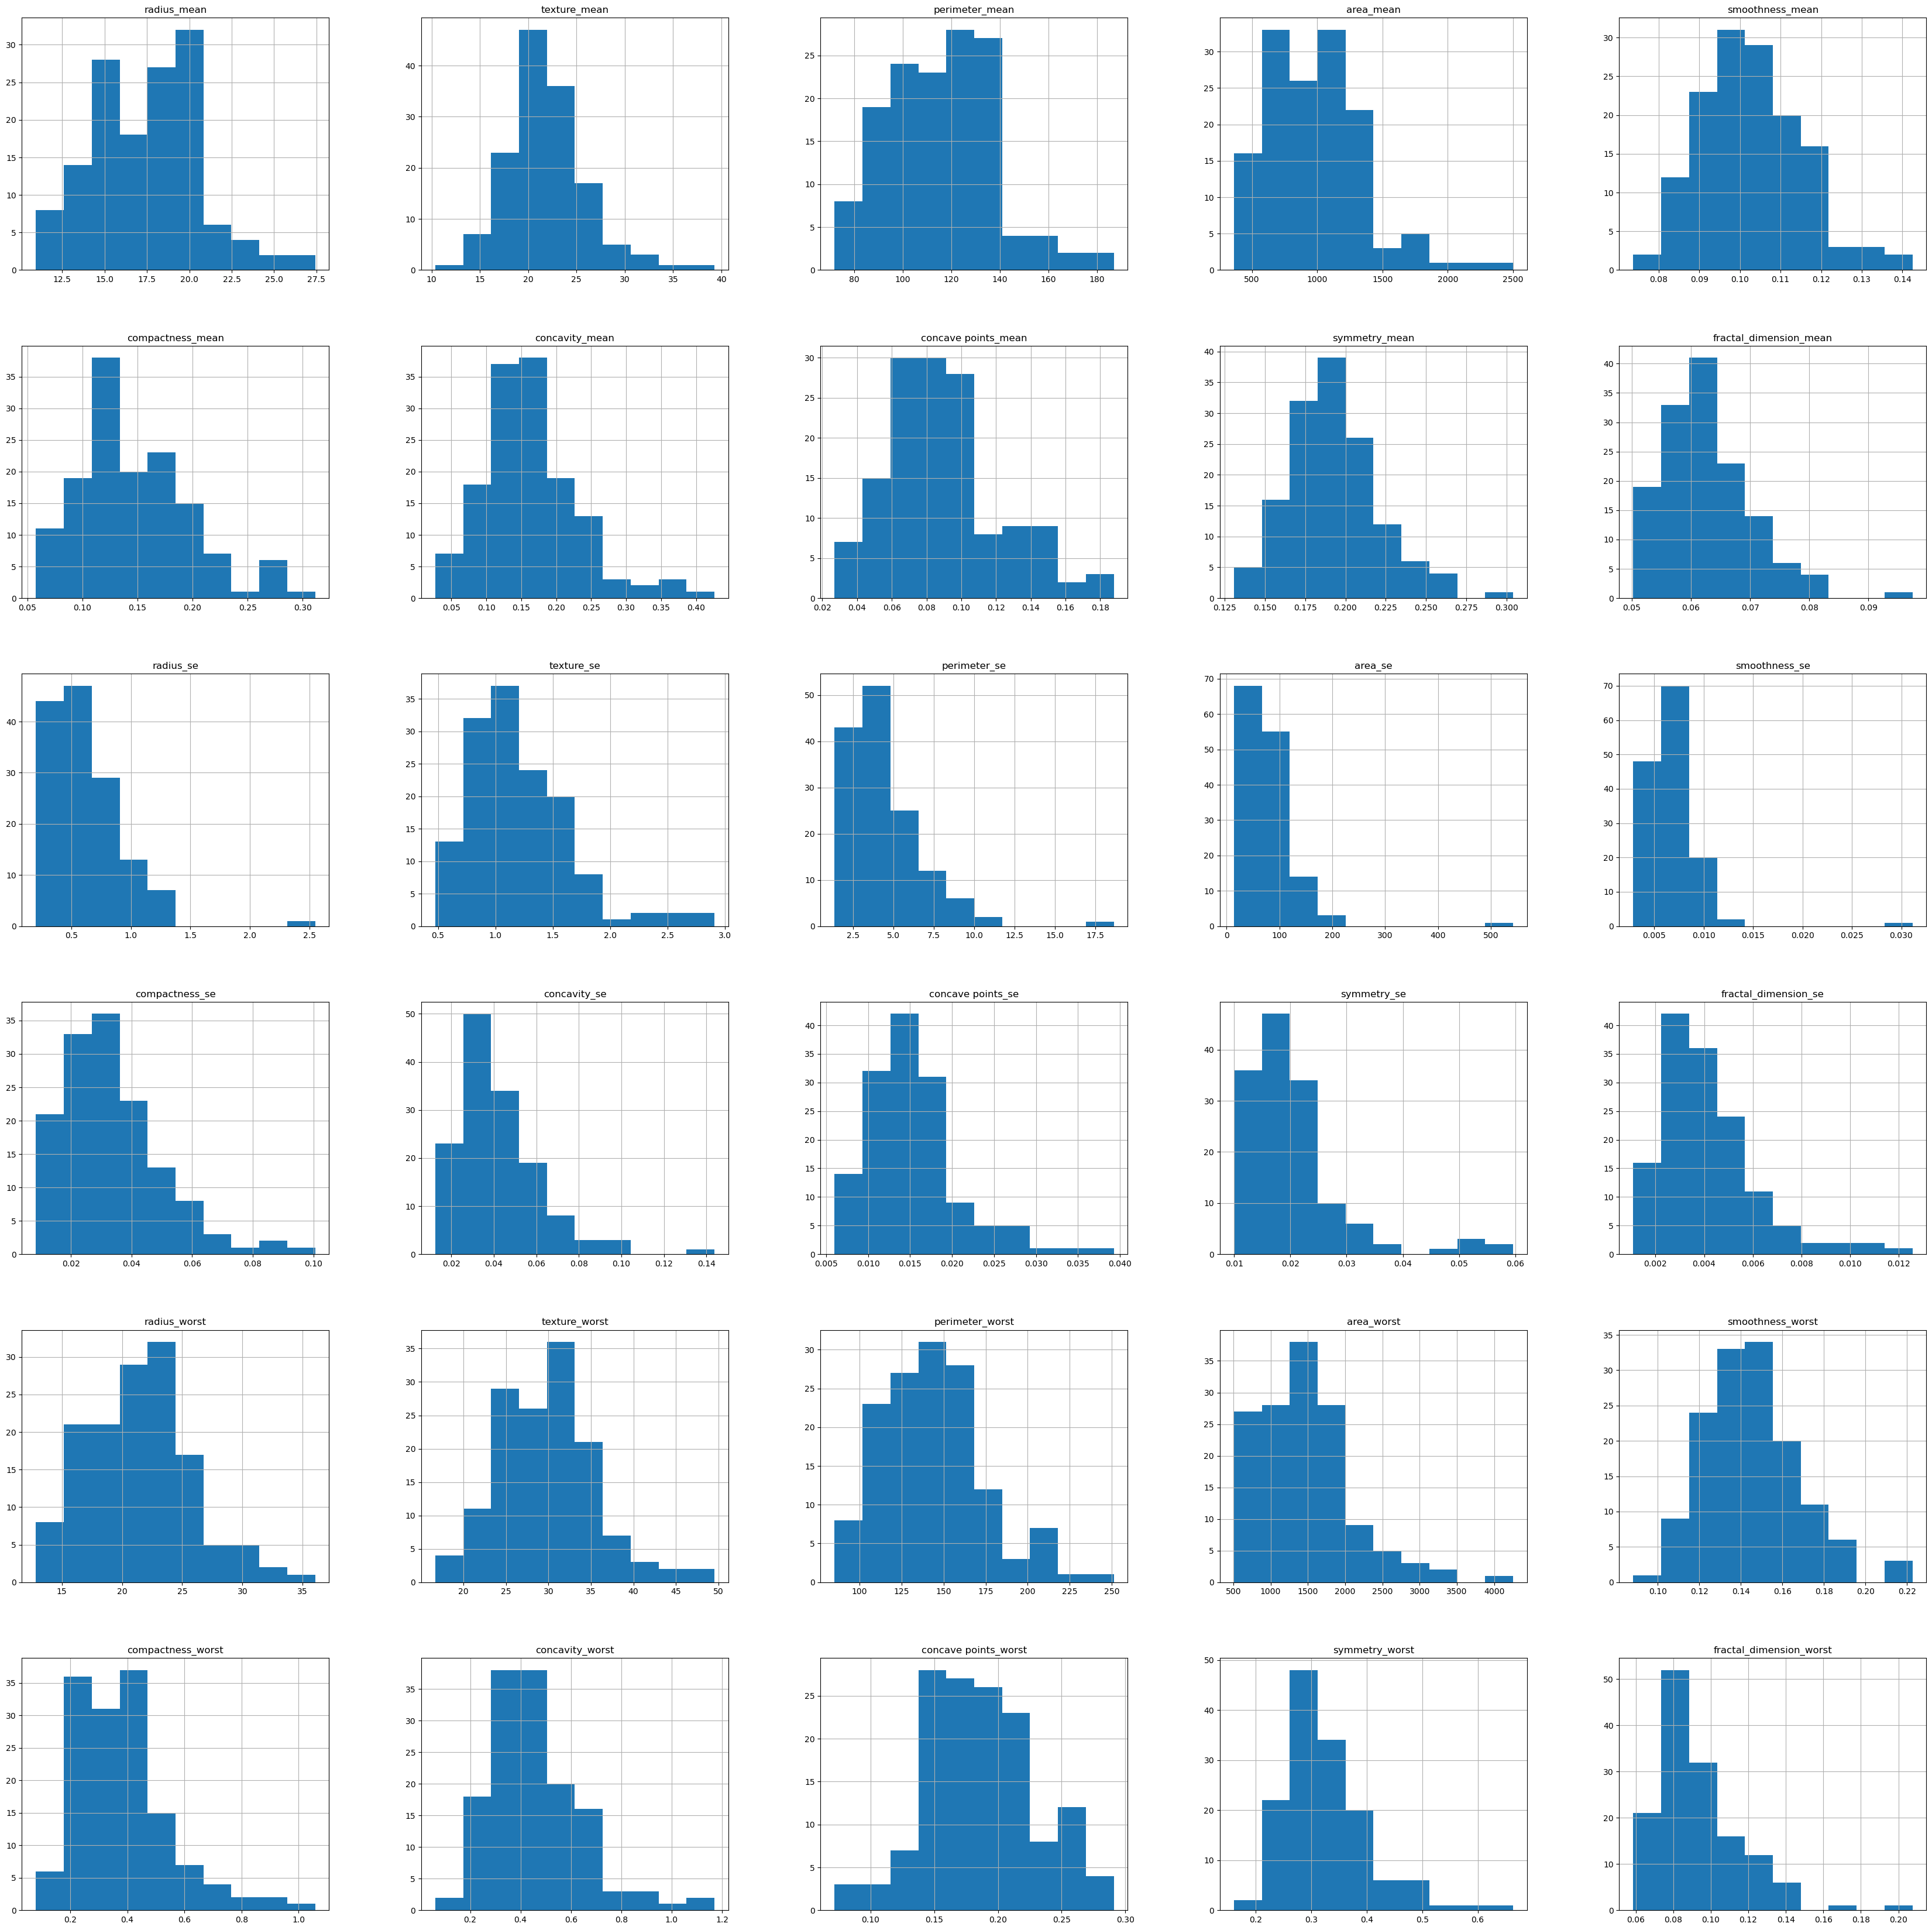

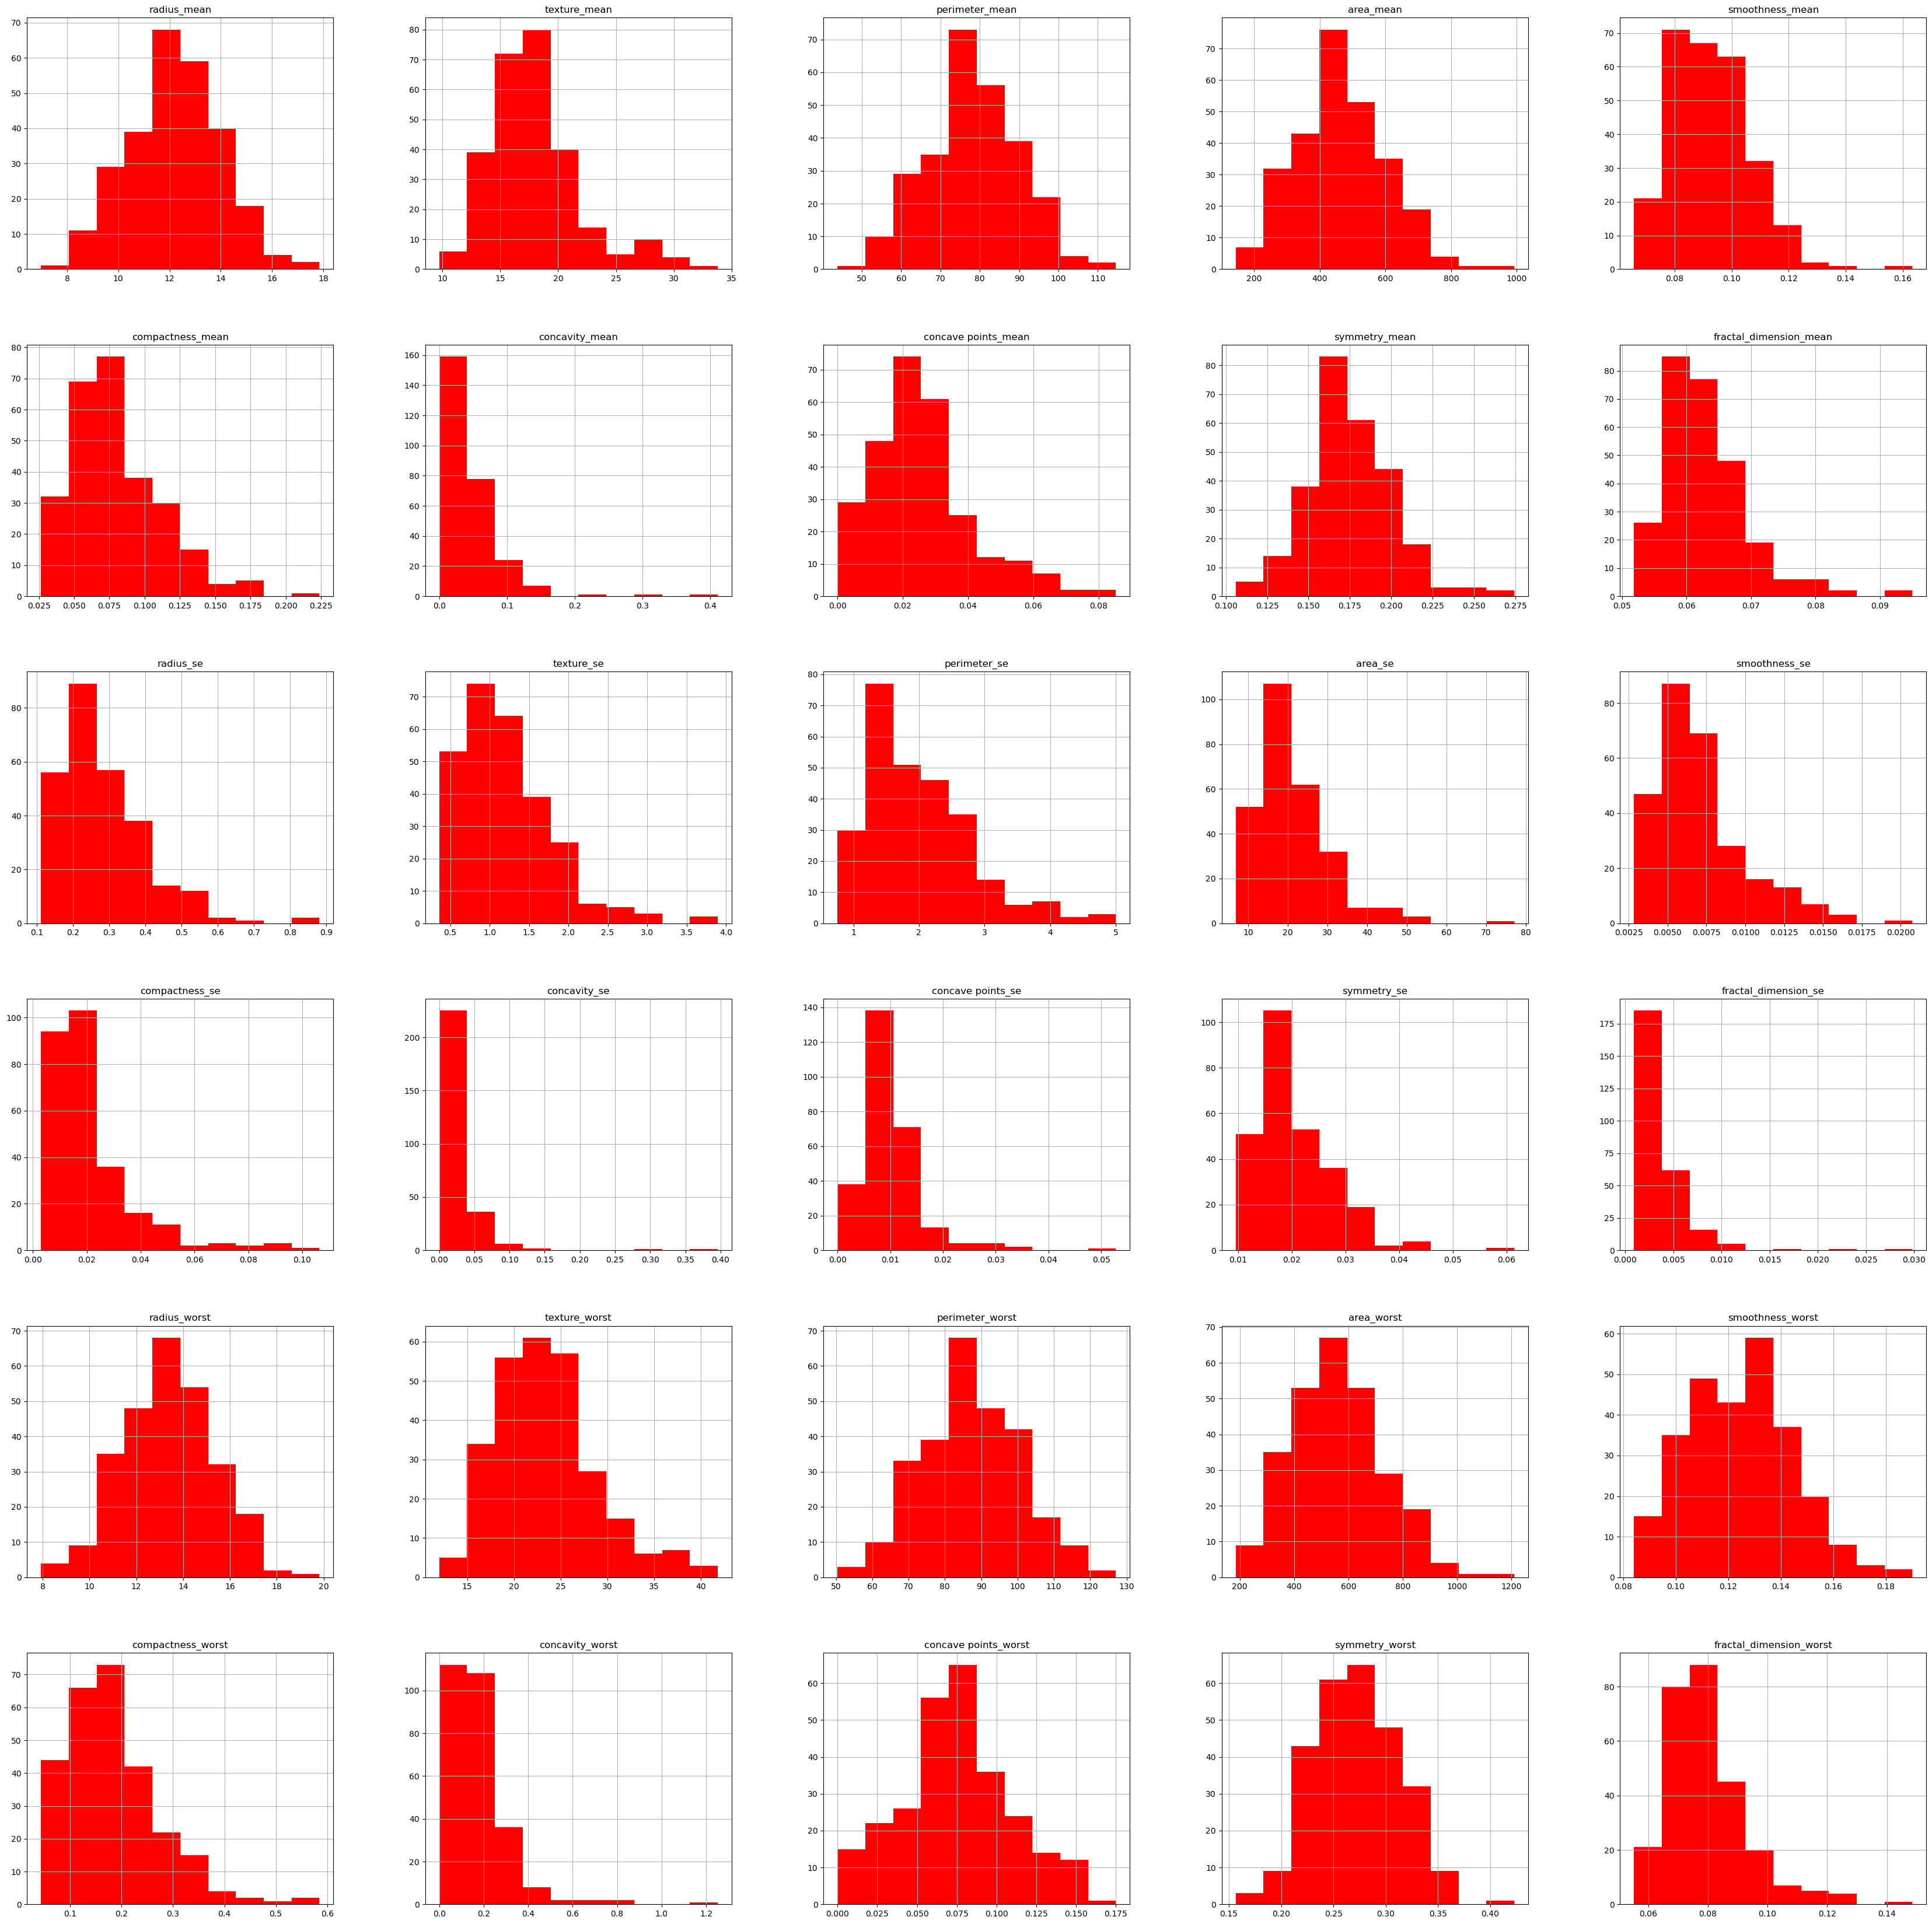

In [ ]:
# Shuffle the data
dev_set_filled = dev_set_filled.sample(frac=1)
# Make plots for initial exploration
m_dev = dev_set_filled[dev_set_filled['diagnosis']=='M']
b_dev = dev_set_filled[dev_set_filled['diagnosis']=='B']
print(f"Malignant: {len(m_dev)}")
print(f"Benign: {len(b_dev)}")
# Plot the distributions
m_dev.hist(figsize = (42,42))
b_dev.hist(figsize = (42,42), color='red')
plt.show()

<p>The histograms above show how each numeric variable is distributed in each group of the target variable. Although it is only a visual representation, it gives us a first idea of whether we expect to see specific variables making the classes separable. For instance, although most of the distributions differ to some extent, radius mean seems to differ significantly between the classes. It goes without saying that a more robust approach will take place in the next steps.</p>

Malignant: 50
Benign: 50


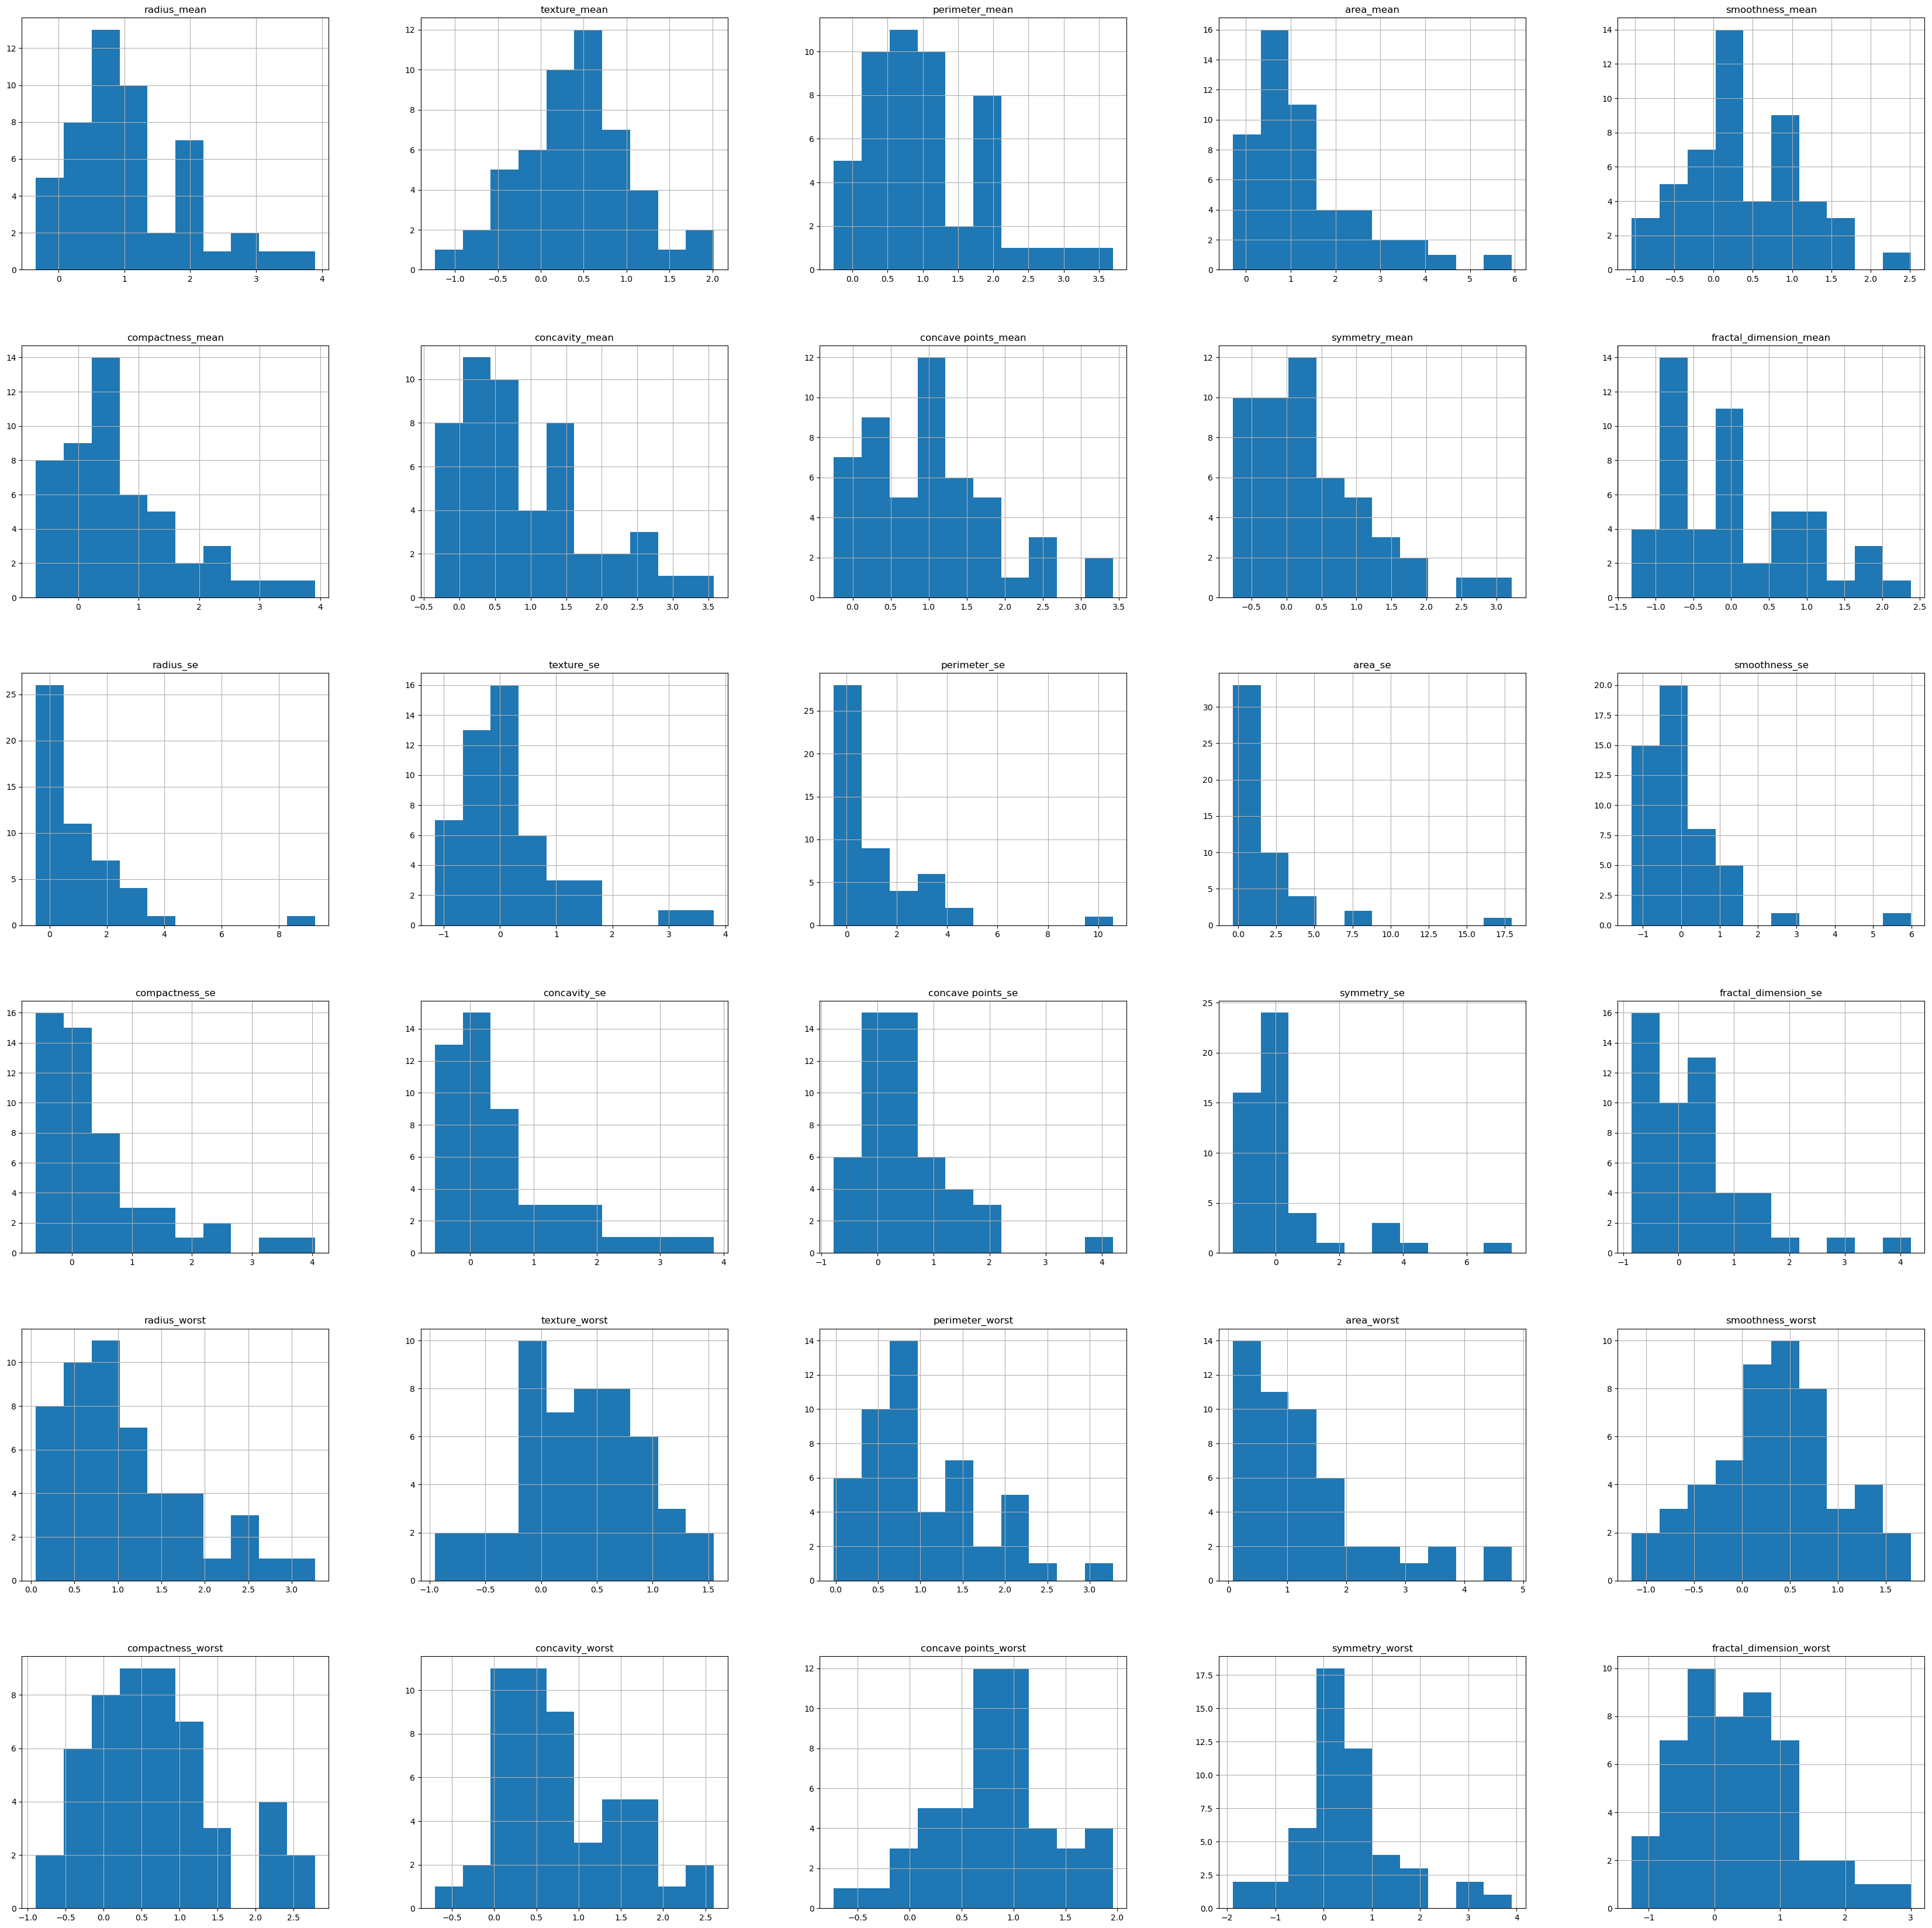

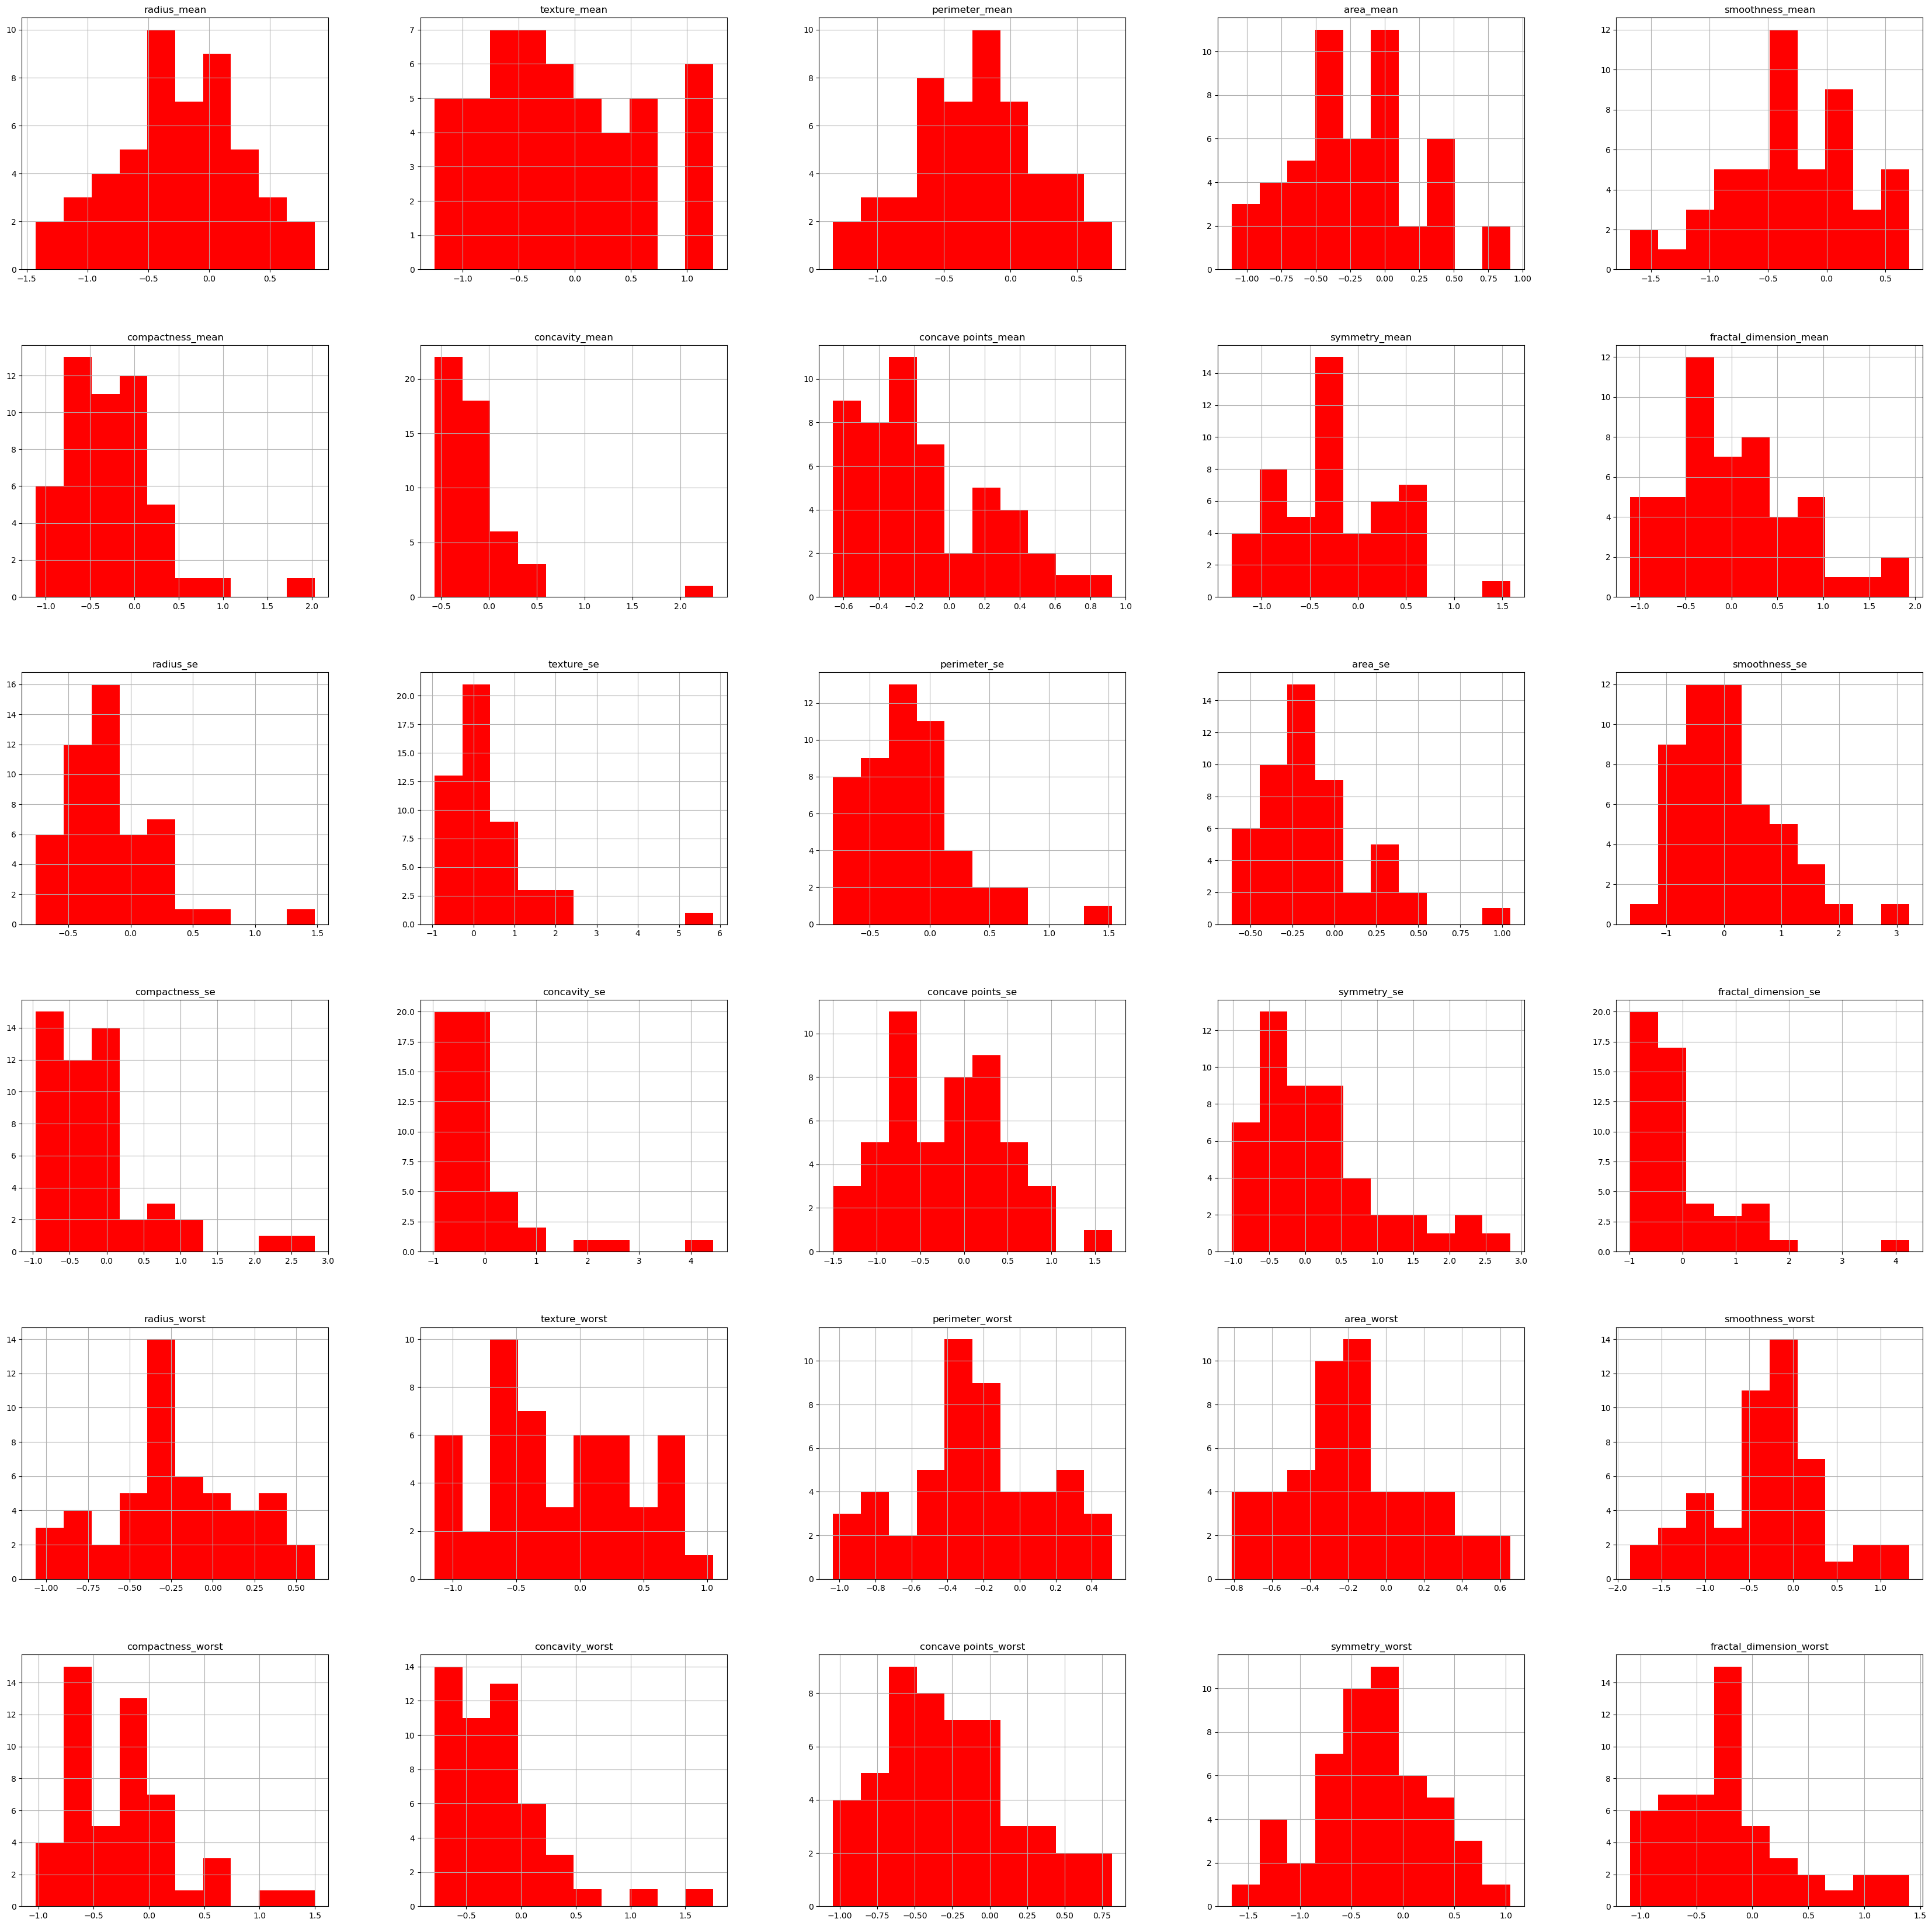

In [48]:
# Make plots for initial exploration
m_eval = eval_set_filled[eval_set_filled['diagnosis']=='M']
b_eval = eval_set_filled[eval_set_filled['diagnosis']=='B']
print(f"Malignant: {len(m_eval)}") 
print(f"Benign: {len(b_eval)}")

m_eval.hist(figsize = (42,42))
b_eval.hist(figsize = (42,42), color='red')
plt.show()

<hr>

<p>Additionally, we will create a heatmap for visualizing the collinearity between the features. For that purpose, since all features are numeric, we can use the Pearson correlation coefficient to measure the linear relationship between them. We keep the upper triangle for cleaner visualization, as viewing the full matrix adds unnecessary complexity. It is worth mentioning that since this explores linear relationships, we might be missing non-linear relationships that might exist in the data.</p>

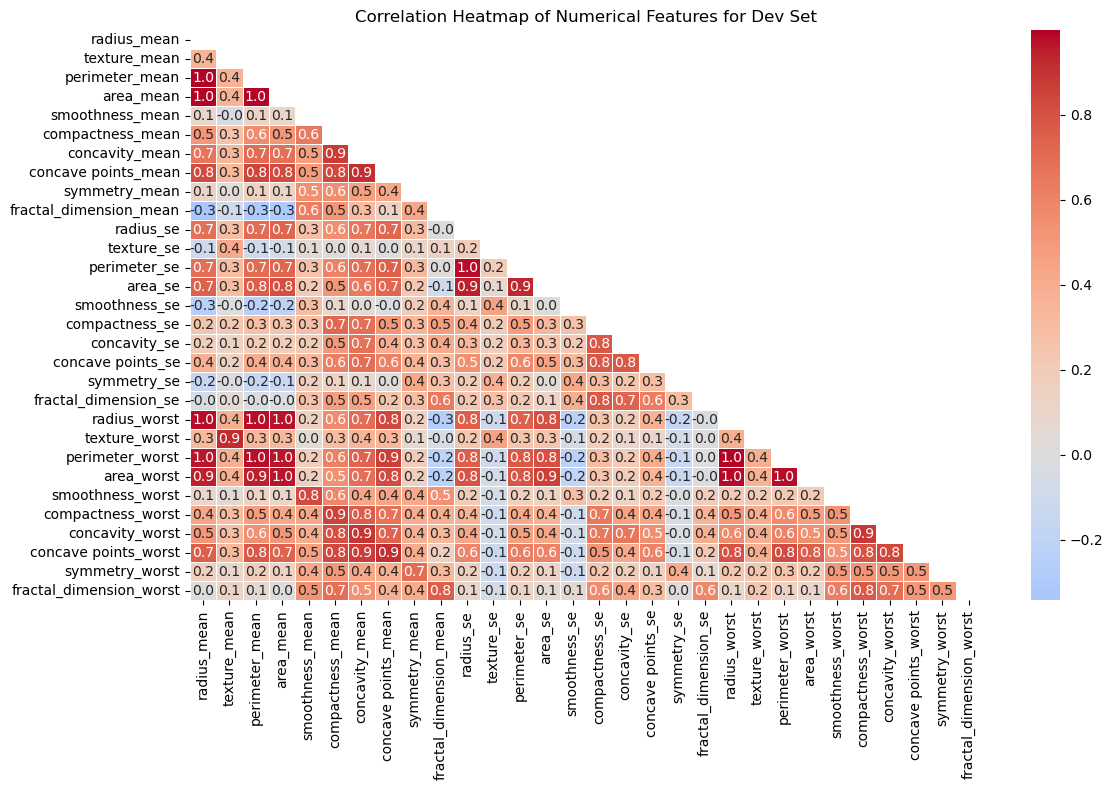

In [47]:
# Make a correlation heatmap (this is valid even after scaling)
dev_set_filled = pd.read_csv(root / "data" / "dev_set_filled.csv", header=0)
corr = dev_set_filled.drop(columns=['diagnosis']).corr()
# Create a mask for the upper triangle for cleaner visualization
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".1f", mask=mask)
plt.title("Correlation Heatmap of Numerical Features for Dev Set")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<p>From the heatmap above we can see that there are various types of correlations between the variables. The most notable ones would be those with the higher correlation scores (close to 1). Apparently we can expect specific pairs of values to have such a strong correlation from a priori knowledge. For instance some radius metrics are expected to be correlated with perimeter ones.</p>


<p>Before applying any scaling technique it is worth plotting each variable's distribution as a boxplot. This way we will get an idea of how many outliers exist visually and will be able to decide whether to use RobustScaler or StandardScaler.</p>

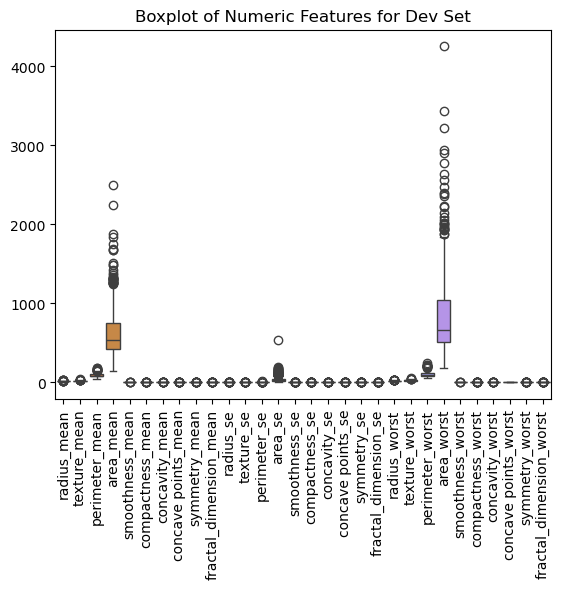

In [24]:
sns.boxplot(data=dev_set_filled.drop(columns=['diagnosis']))
plt.xticks(rotation=90)
plt.title("Boxplot of Numeric Features for Dev Set")
plt.show()

<p>Due to the different scales of the variables, two of them dominate the plot and as is shown contain a good ammount of outliers. After plotting the distrinutions for smaller scales (not shown here), it became apparent that this is the case for some of the other variables as well. Thus, RobustScaler is used to handle the outliers.</p>

In [26]:
# Since there is a considerable amount of outliers in the data, we will use the RobustScaler to handle them
scaler = RobustScaler()
cols_to_scale = [col for col in dev_set_filled.columns if col not in ['diagnosis']]
dev_set_filled[cols_to_scale] = scaler.fit_transform(dev_set_filled[cols_to_scale])
# Save the scaler and load it for the evaluation set
joblib.dump(scaler, root / "models" / "RobustScaler.pkl")
scaler = joblib.load(root / "models" / "RobustScaler.pkl")
eval_set_filled[cols_to_scale] = scaler.transform(eval_set_filled[cols_to_scale])
# Save the preprocessed data
dev_set_filled.to_csv(root / "data" / "dev_set_final.csv", index=False)
eval_set_filled.to_csv(root / "data" / "eval_set_final.csv", index=False)

<p>Here we use mutual information because it is appropriate for categorical variables.</p>

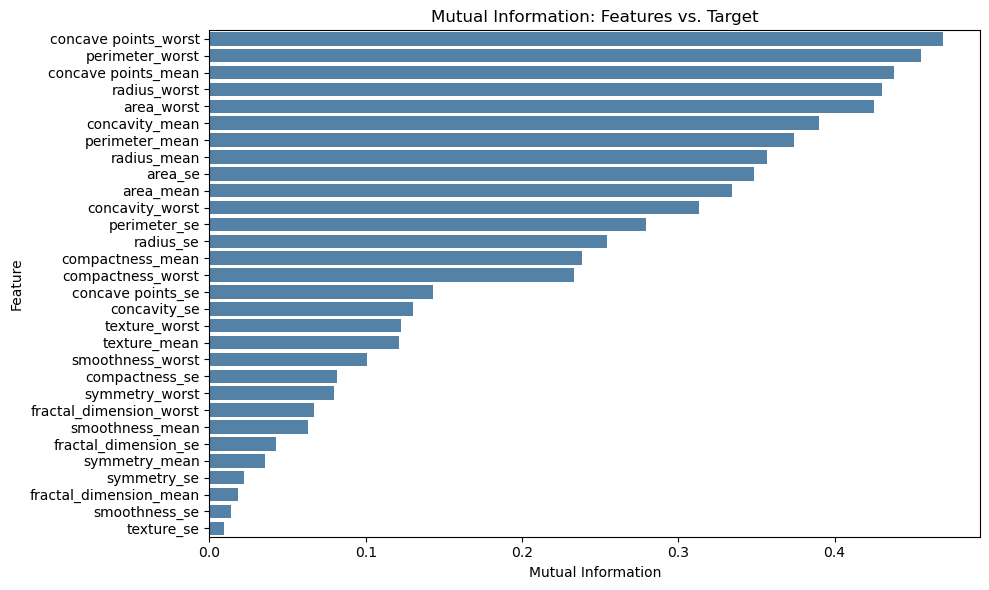

In [3]:
# In order to get a feel of correlations with the target
# which is categorical, we can use the mutual_info_classif function
# since it handles also non-linear relationships
from sklearn.feature_selection import mutual_info_classif
dev_set_final = pd.read_csv(root / "data" / "dev_set_final.csv")
x = dev_set_final.drop(columns=['diagnosis'])
y = dev_set_final['diagnosis']
mi = mutual_info_classif(x, y)
# Make a DataFrame
mi_df = pd.DataFrame({'Feature': x.columns, 'Mutual Information': mi})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df, color='steelblue')
plt.title("Mutual Information: Features vs. Target")
plt.tight_layout()
plt.show()

In [4]:
pca = PCA(n_components=0.95)
pca = pca.fit(x)
x = pca.transform(x)
print(pca.n_components_)

10


In [7]:
# Replace B with 0 and M with 1 in the diagnosis column
dev_set_final['diagnosis'] = dev_set_final['diagnosis'].replace({'B': 0, 'M': 1})
dev_set_final.to_csv(root / "data" / "dev_set_final.csv", index=False)
eval_set_final = pd.read_csv(root / "data" / "eval_set_final.csv", header=0)
eval_set_final['diagnosis'] = eval_set_final['diagnosis'].replace({'B': 0, 'M': 1})
eval_set_final.to_csv(root / "data" / "eval_set_final.csv", index=False)
y = dev_set_final['diagnosis']

/var/folders/mt/l606mr6x07q49h97jslphwm40000gn/T/ipykernel_8506/3968691356.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  eval_set_final['diagnosis'] = eval_set_final['diagnosis'].replace({'B': 0, 'M': 1})


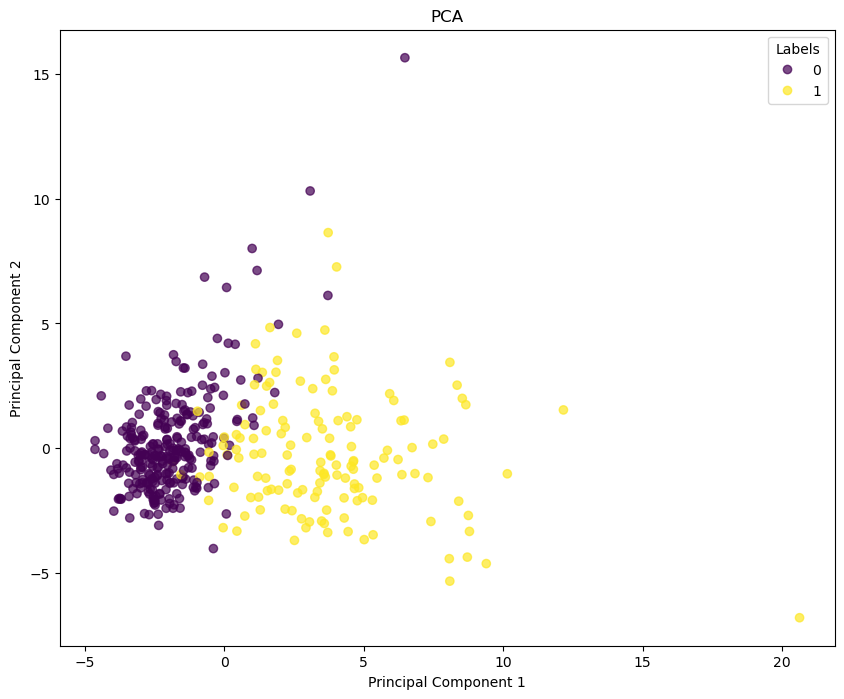

Explained variance ratio: [0.4507855  0.19585446 0.09248025 0.06173916 0.04886985 0.03781035
 0.02592684 0.01659534 0.01379755 0.01170141]


In [8]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x[:, 0], x[:, 1], c=y.values, cmap='viridis', alpha=0.7)

# Add a legend (optional, if labels are categorical)
plt.legend(*scatter.legend_elements(), title="Labels")
plt.title("PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()
print("Explained variance ratio:", pca.explained_variance_ratio_)

<p>Based on the plot below the two classses seems to be able to be well separated after the trandformation. There is a small overlap in the plot, but by keeping the number of components that explain 95% of the variance, we can mitigate this issue.</p>

In [9]:
joblib.dump(pca, root/'models'/'pca.pkl')

['/Users/rafailadam/Downloads/Assignment-2/models/pca.pkl']